In [1]:
%load_ext tensorboard
%load_ext autoreload

%set_env CUDA_LAUNCH_BLOCKING=0

env: CUDA_LAUNCH_BLOCKING=0


In [2]:
%tensorboard --logdir lightning_logs

In [3]:
%autoreload 2

import pytorch_lightning as lightning

import torch
from torch.utils.data import Subset
from torchvision.datasets import MNIST
from torchvision import transforms

from sklearn.datasets import make_moons, make_circles

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

from data import UnlabeledDataset, SingleTensorDataset
from modules import DenseARQ, DenseFlow, ImageARQ, ImageFlow


from FrEIA.modules import GLOWCouplingBlock, LinearSpline, RationalQuadraticSpline
from marcel import RQNSFCouplingBlock

import utils

In [4]:
plt.rc("figure", dpi=200)
plt.rc("legend", fontsize=6)

In [5]:
accelerator = "gpu"
devices = 1

In [6]:
torch.autograd.set_grad_enabled(False)

## Benchmarks and Errors

New algorithm vs. existing implementation by Marcel Meyer

In [7]:
batch_size = 1000
input_shape = (2,)

x = torch.randn(batch_size, *input_shape)
x = (x,)

def subnet(dims_in, dims_out):
    global x
    import torch.nn as nn

    if x[0].dim() == 4:
        net = nn.Sequential(
            nn.Conv2d(dims_in, 64, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=1, padding="same"),
            nn.ReLU(),
            nn.Conv2d(64, dims_out, kernel_size=3, padding="same"),
        )
    else:
        net = nn.Sequential(
            nn.Linear(dims_in, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, dims_out)
        )

    net[-1].weight.data.fill_(0.0)
    net[-1].bias.data.fill_(0.0)
    return net

affine = GLOWCouplingBlock((input_shape,), subnet_constructor=subnet)
rqs = RationalQuadraticSpline((input_shape,), subnet_constructor=subnet, bins=8)
rqnsf = RQNSFCouplingBlock((input_shape,), subnet_constructor=subnet, n_bins=8, left=-1.0, right=1.0, bottom=-1.0, top=1.0)

In [8]:
%%timeit
z, logdet = affine.forward(x)

477 µs ± 10.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [9]:
z, logdet = affine.forward(x)

In [10]:
%%timeit
xx, logdet = affine.forward(z, rev=True)

487 µs ± 21.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [11]:
xx, logdet = affine.forward(z, rev=True)

mse = utils.sum_except_batch((x[0] - xx[0]) ** 2).mean()
mse

tensor(0.)

In [12]:
%%timeit
z, logdet = rqs.forward(x)

1.94 ms ± 30.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [13]:
z, logdet = rqs.forward(x)

In [14]:
%%timeit
xx, logdet = rqs.forward(z, rev=True)

2.05 ms ± 23.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
xx, logdet = rqs.forward(z, rev=True)

mse = utils.sum_except_batch((x[0] - xx[0]) ** 2).mean()
mse

tensor(4.5556e-14)

In [16]:
%%timeit
z, logdet = rqnsf.forward(x)

/home/lars/code/python/neural-spline-flows/marcel/coupling_layers.py:649: UserWarning: InputOutsideDomain: min -1.9871337413787842; max 1.0 + 2.6504430770874023
  warnings.warn(
/home/lars/code/python/neural-spline-flows/marcel/coupling_layers.py:723: UserWarning: InputOutsideDomain: min -2.093219518661499; max 1.0 + 2.0302727222442627
  warnings.warn(


1.47 ms ± 11.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [17]:
z, logdet = rqnsf.forward(x)

In [18]:
%%timeit
xx, logdet = rqnsf.forward(z, rev=True)

1.54 ms ± 14.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [19]:
xx, logdet = rqnsf.forward(z, rev=True)

mse = utils.sum_except_batch((x[0] - xx[0]) ** 2).mean()
mse

tensor(0.2985)

## Training Examples

In [20]:
def make_blobs(samples_per_blob: int = 100, *, centers: int = 8, radius: float = 10.0, std: float = 1.0, shuffle=True):
    """ Make 2D gaussian blobs distributed equally on a circle about the origin """
    phis = np.linspace(0, 2 * np.pi, num=centers + 1)[:-1]
    means = np.empty((centers, 2))
    means[:, 0] = radius * np.cos(phis)
    means[:, 1] = radius * np.sin(phis)

    samples = np.random.normal(means, std, size=(samples_per_blob, centers, 2))
    labels = np.resize(np.arange(centers), (samples_per_blob, centers))

    # flatten
    samples = samples.reshape(samples_per_blob * centers, 2)
    labels = labels.reshape(-1)

    if shuffle:
        sort = np.random.permutation(len(samples))
        samples = samples[sort, ...]
        labels = labels[sort, ...]

    return samples, labels

In [21]:
def make_data(dataset: str, n_train: int = 10000, n_val: int = 1000, plot: bool = True, *args, **kwargs):
    match dataset.lower():
        case "moons":
            make = make_moons
        case "circles":
            make = make_circles
        case "blobs":
            make = make_blobs
        case _:
            raise ValueError(f"Unsupported dataset: {dataset}")

    train_x, train_y = make(n_train, *args, **kwargs)
    val_x, _ = make(n_val, *args, **kwargs)
    
    # normalize
    mean, std = train_x.mean(axis=0), train_x.std(axis=0)
    train_x = (train_x - mean) / std
    val_x = (val_x - mean) / std

    if plot:
        # plot true distribution as kde
        kde = gaussian_kde(train_x.T)

        xmin, ymin = np.min(train_x, axis=0)
        xmax, ymax = np.max(train_x, axis=0)

        xmin, ymin = xmin - 1, ymin - 1
        xmax, ymax = xmax + 1, ymax + 1

        nx, ny = 1000, 1000

        x = np.linspace(xmin, xmax, nx, dtype=np.float32)
        y = np.linspace(ymin, ymax, ny, dtype=np.float32)

        xx, yy = np.meshgrid(x, y)
        x, y = xx.flatten(), yy.flatten()
        xy = np.stack((x, y), axis=1)
        xy = torch.from_numpy(xy)

        likelihood = kde(xy.T)
        likelihood = likelihood.reshape(nx, ny)

        plt.figure(dpi=500)
        artist = plt.imshow(likelihood, cmap="inferno", extent=(xmin, xmax, ymin, ymax), origin="lower")
        # plt.scatter(train_x[:, 0], train_x[:, 1], s=1, c="white", marker=".", alpha=0.25)
        plt.colorbar(artist, fraction=0.046, pad=0.04)
        plt.title("True Distribution")
        plt.xlabel("$x_1$")
        plt.ylabel("$x_2$")

        plt.tight_layout()
        plt.savefig(f"plots/{dataset.lower()}_true.png")
        plt.show()

    train_data = SingleTensorDataset(train_x.astype(np.float32))
    val_data = SingleTensorDataset(val_x.astype(np.float32))

    return train_data, val_data

In [22]:
def make_model(name: str, train_data, val_data, **hparams):
    match name.lower():
        case "additive":
            model = DenseFlow(train_data, val_data, coupling_type="additive", steps=24, **hparams)
        case "affine":
            model = DenseFlow(train_data, val_data, coupling_type="affine", steps=24, **hparams)
        case "linear_spline":
            model = DenseFlow(train_data, val_data, coupling_type="linear_spline", steps=20, coupling_args={"bins": 16}, **hparams)
        case "rq_spline":
            model = DenseFlow(train_data, val_data, coupling_type="rq_spline", steps=20, coupling_args={"bins": 8}, **hparams)
        case _:
            raise ValueError(f"Unsupported model type: {name}")

    return model

In [23]:
def generate_and_plot(model, shape=(1000,), temperature=0.8, image_shape=(1000, 1000), lims=None):
    samples = model.generate(shape=shape, temperature=temperature).cpu().numpy()

    if lims is None:
        xmin, ymin = np.min(samples, axis=0)
        xmax, ymax = np.max(samples, axis=0)

        xmin, ymin = xmin - 1, ymin - 1
        xmax, ymax = xmax + 1, ymax + 1
    else:
        xmin, xmax, ymin, ymax = lims
    
    nx, ny = image_shape

    x = np.linspace(xmin, xmax, nx, dtype=np.float32)
    y = np.linspace(ymin, ymax, ny, dtype=np.float32)

    xx, yy = np.meshgrid(x, y)
    x, y = xx.flatten(), yy.flatten()
    xy = np.stack((x, y), axis=1)
    xy = torch.from_numpy(xy).to(model.device)

    likelihood = np.exp(model.log_likelihood(xy).cpu().numpy())
    likelihood = likelihood.reshape(nx, ny)

    plt.figure(dpi=500)
    artist = plt.imshow(likelihood, cmap="inferno", extent=(xmin, xmax, ymin, ymax), origin="lower")
    # plt.scatter(samples[:, 0], samples[:, 1], s=1, c="white", marker=".", alpha=0.25)
    plt.colorbar(artist, fraction=0.046, pad=0.04)
    plt.title("Learned Likelihood and Samples")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")

In [24]:
class LikelihoodVideoCallback(lightning.callbacks.Callback):
    def __init__(self, name, title_name, dataset_name):
        self.name = name
        self.title_name = title_name
        self.dataset_name = dataset_name

    def on_train_epoch_start(self, trainer: "lightning.Trainer", pl_module: "lightning.LightningModule") -> None:
        """Called when the train epoch begins."""
        pl_module.eval()
        with torch.no_grad():
            generate_and_plot(pl_module, lims=(-3, 3, -3, 3))

            plt.title(f"Learned Likelihood of {self.title_name} in Epoch {trainer.current_epoch:04d}")
            plt.tight_layout()
            plt.savefig(f"plots/{self.dataset_name.lower()}_learned_{self.name.lower()}_epoch_{trainer.current_epoch:04d}.png")
            plt.close()
        
        pl_module.train()

In [25]:
def train_model(model, name, title_name, dataset_name, **kwargs):
    trainer = lightning.Trainer(
        accelerator=accelerator,
        devices=devices,
        benchmark=True,
        callbacks=[LikelihoodVideoCallback(name, title_name, dataset_name)],
        **kwargs
    )

    with torch.autograd.enable_grad():
        model.train()
        trainer.fit(model)

    best_model = model.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
    best_model.eval()

    return best_model

In [26]:
def compare(dataset: str, model_names: list[str], hparams: dict, max_epochs: int = 100, *data_args, **data_kwargs):
    if data_kwargs is None:
        data_kwargs = {}

    train_data, val_data = make_data(dataset, *data_args, **data_kwargs)

    for name in model_names:
        model = make_model(name, train_data, val_data, **hparams)

        match name.lower():
            case "affine":
                title_name = "Affine Flow"
            case "linear_spline":
                title_name = "Linear Spline Flow"
            case "rq_spline":
                title_name = "RQ Spline Flow"
            case _:
                title_name = name

        model = train_model(model, name=name, title_name=title_name, dataset_name=dataset, max_epochs=max_epochs)

        generate_and_plot(model)

        plt.title(f"Learned Likelihood of {title_name}")
        plt.tight_layout()
        plt.savefig(f"plots/{dataset.lower()}_learned_{name.lower()}.png")
        plt.show()

In [27]:
features = 2
train_samples = 10000
val_samples = 1000
noise = 0.05

input_shape = (features,)

In [28]:
hparams = dict(
    input_shape=input_shape,
    batch_size=128,
    subnet_widths=[64, 128, 64],
    learning_rate=1e-3,
)

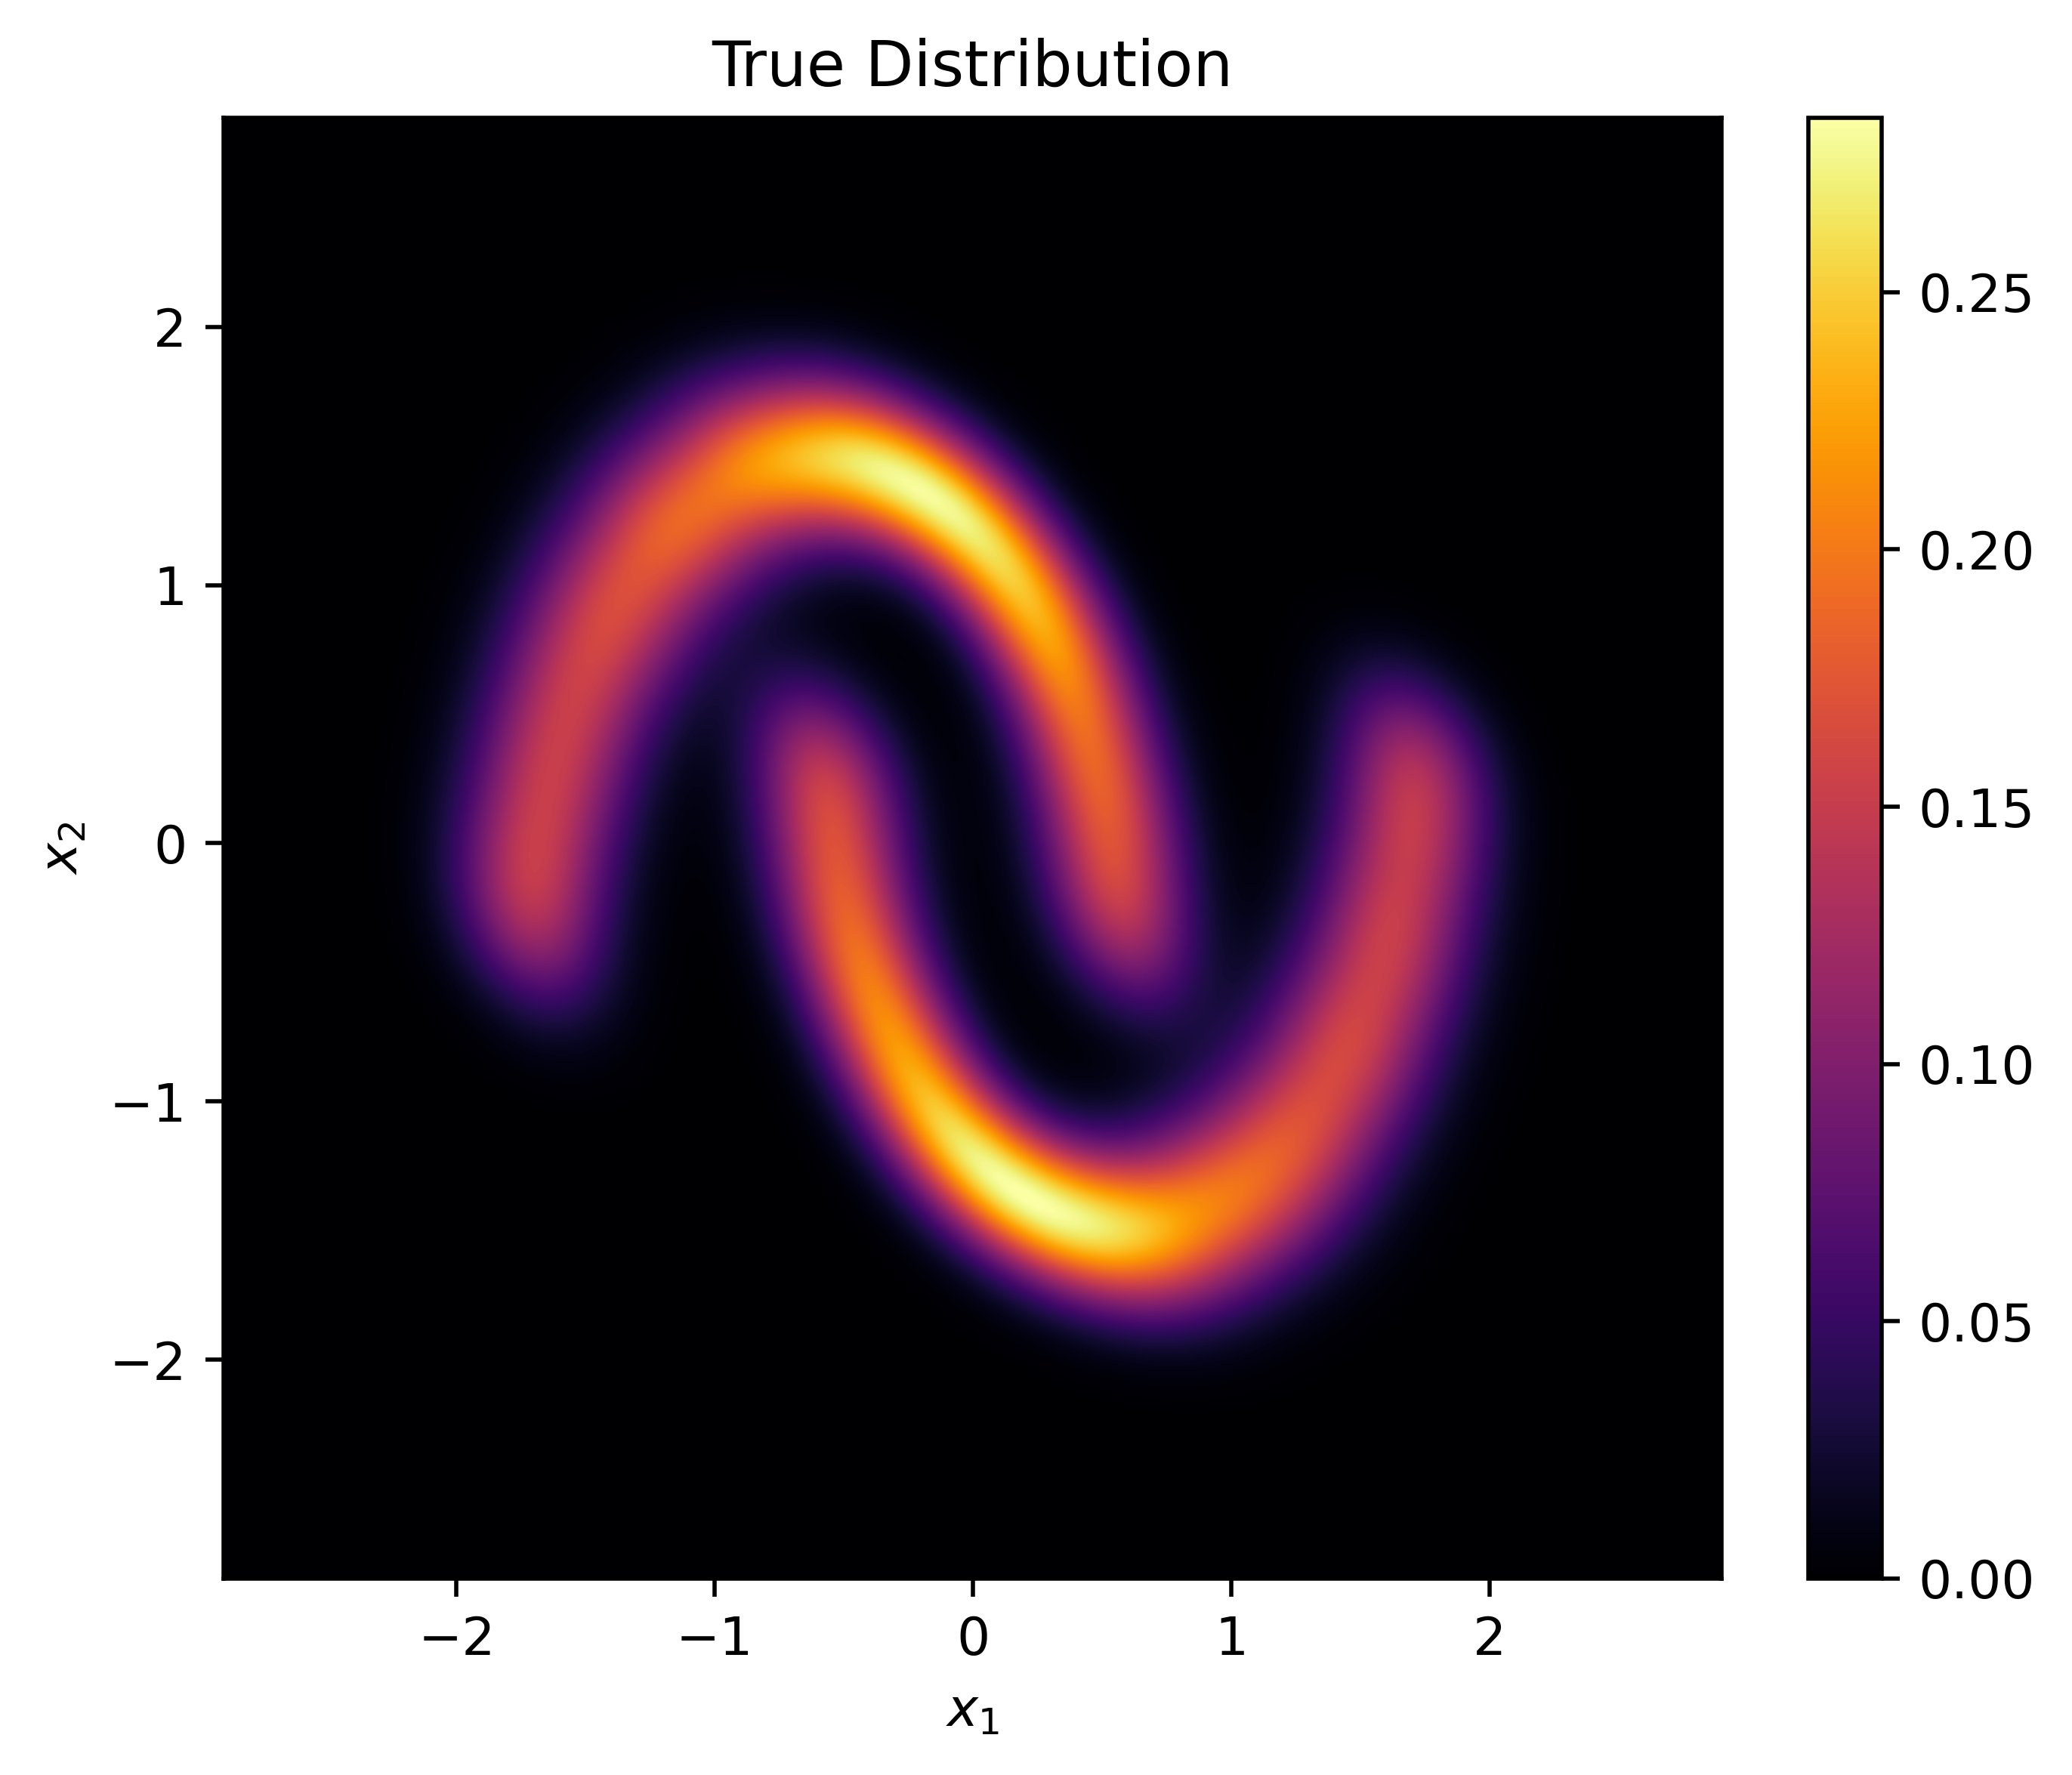

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
Missing logger folder: /home/lars/code/python/neural-spline-flows/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type     | Params
----------------------------------
0 | inn  | GraphINN | 808 K 
----------------------------------
808 K     Trainable params
0         Non-trainable params
808 K     Total params
3.232     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
compare("moons", ["affine", "linear_spline", "rq_spline"], hparams, max_epochs=100, n_train=2 * train_samples, n_val=2 * val_samples, noise=noise)

In [ ]:
compare("circles", ["affine", "linear_spline", "rq_spline"], hparams, max_epochs=100, n_train=2 * train_samples, n_val=2 * val_samples, noise=noise, factor=0.5)

In [ ]:
compare("blobs", ["affine", "linear_spline", "rq_spline"], hparams, max_epochs=100, n_train=train_samples, n_val=val_samples)

In [ ]:
input_shape = (3, 2, 2)

In [ ]:
red = torch.eye(2)
green = torch.Tensor([
    [0, 1],
    [0, 0],
])
blue = 1 - red


img1 = torch.stack((red, green, blue))

In [ ]:
red = torch.Tensor([
    [1, 1],
    [0, 0],
])
green = torch.eye(2)
blue = 1 - red

img2 = torch.stack((red, green, blue))

In [ ]:
plt.imshow(img1.movedim(0, -1))
plt.savefig("plots/test1.png")
plt.show()

plt.imshow(img2.movedim(0, -1))
plt.savefig("plots/test2.png")
plt.show()

In [ ]:
n_train = 128

train_x = torch.stack((img1, img2))
train_x = train_x.repeat(n_train, 1, 1, 1)
val_x = train_x.clone()

train_data = SingleTensorDataset(train_x)
val_data = SingleTensorDataset(val_x)

In [ ]:
hparams = dict(
    input_shape=input_shape,
    subnet_widths=[64, 64],
    kernel_sizes=[3, 1, 3],
    optimizer="adam",
)

In [ ]:
model = ImageFlow(train_data, val_data, batch_size=32, coupling_type="rq_spline", coupling_args={"bins": 8}, steps=16, **hparams)

In [ ]:
model = train_model(model, max_epochs=100)

In [ ]:
samples = model.generate(shape=(9,), temperature=0.8).movedim(1, -1)
fig = plt.figure()

for i, s in enumerate(samples):
    plt.subplot(3, 3, i + 1)
    plt.imshow(s)

fig.suptitle("Model Samples")
plt.savefig("plots/samples_test.png")
plt.show()

In [ ]:
input_shape = (3, 16, 16)

In [ ]:
transform = transforms.Compose([
    # lower bit depth
    transforms.RandomPosterize(bits=5, p=1),
    # change to tensor
    transforms.PILToTensor(),
    # change data type and normalize to [0, 1]
    transforms.ConvertImageDtype(torch.float32),
    # bi-linear upscale
    transforms.Resize(input_shape[1:]),

    # grayscale to rgb
    lambda x: x.expand(input_shape),
])

In [ ]:
def filter_labels(dataset, keep=None, drop=None):
    match (keep, drop):
        case (None, None):
            raise ValueError(f"Must specify exactly one of keep or drop.")
        case (keep, None):
            mask = torch.isin(dataset.targets, torch.as_tensor(keep))
        case (None, drop):
            mask = ~torch.isin(dataset.targets, torch.as_tensor(drop))
        case _:
            raise ValueError(f"Must specify exactly one of keep or drop.")

    return Subset(dataset, mask.nonzero().squeeze())

In [ ]:
train_data = MNIST(root="mnist", train=True, download=True, transform=transform)
val_data = MNIST(root="mnist", train=False, download=True, transform=transform)

keep = [5]

train_data = filter_labels(train_data, keep=keep)
val_data = filter_labels(val_data, keep=keep)

print(f"{len(train_data)} images in train set")
print(f"{len(val_data)} images in validation set")

In [ ]:
train_data = UnlabeledDataset(train_data)
val_data = UnlabeledDataset(val_data)

In [ ]:
sample = np.random.randint(len(train_data))
x = train_data[sample].movedim(0, -1)
plt.imshow(x)
plt.show()

In [ ]:
hparams = dict(
    input_shape=input_shape,
    subnet_widths=[64, 64],
    kernel_sizes=[3, 1, 3],
    optimizer="adam",
)

In [ ]:
affine = ImageFlow(train_data, val_data, batch_size=32, coupling_type="affine", steps=8, **hparams)

In [ ]:
spline = ImageFlow(train_data, val_data, batch_size=32, coupling_type="spline", steps=8, coupling_args={"bins": 2}, **hparams)

In [ ]:
affine = train_model(affine, max_epochs=50, accumulate_grad_batches=4, gradient_clip_val=5.0)

In [ ]:
spline = train_model(spline, max_epochs=50, accumulate_grad_batches=4, gradient_clip_val=5.0)

In [ ]:
samples = affine.generate(shape=(9,), temperature=0.8).movedim(1, -1)

In [ ]:
fig = plt.figure()

for i, s in enumerate(samples):
    plt.subplot(3, 3, i + 1)
    plt.imshow(s)

fig.suptitle("Affine Samples")
plt.savefig("plots/samples_affine.png")
plt.show()

In [ ]:
samples = spline.generate(shape=(9,), temperature=0.8).movedim(1, -1)

In [ ]:
fig = plt.figure()

for i, s in enumerate(samples):
    plt.subplot(3, 3, i + 1)
    plt.imshow(s)

fig.suptitle("Spline Samples")
plt.savefig("plots/samples_spline.png")
plt.show()